In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

In [3]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy

In [4]:
train_irimgs_path = glob.glob('data/TNO/ir/*.png')
train_viimgs_path = glob.glob('data/TNO/vi/*.png')
train_sum = train_irimgs_path.copy()
train_sum.extend(train_viimgs_path)
#

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize(mean=0.5,std=0.5)
])

In [6]:
vi_img = Image.open(train_viimgs_path[1])
ir_img = Image.open(train_irimgs_path[1])
ir_img = ir_img.convert('RGB')

In [7]:
np.array(ir_img).shape,np.array(vi_img).shape

((576, 768, 3), (576, 768, 3))

In [8]:
class FusionDataset(data.Dataset):
    def __init__(self,ir_path,vi_path):
        self.ir_path = train_irimgs_path
        self.vi_path = train_viimgs_path
    def __getitem__(self,idx):
        # 得到路径
        vi_path = self.vi_path[idx]
        ir_path = self.ir_path[idx]
        # 根据路径得到图片
        vi_img = Image.open(vi_path)
        ir_img = Image.open(ir_path) #ir红外读取为灰度秃了

        vi_img = transform(vi_img)
        ir_img = ir_img.convert('RGB')# 将灰度图转换为三通道再变化
        ir_img = transform(ir_img)
        return vi_img,ir_img
    def __len__(self):
        return len(self.ir_path)
        

In [9]:
class AEDataset(data.Dataset):
    def __init__(self,path):
        self.path = path
    def __getitem__(self,idx):
        # 得到路径
        path = self.path[idx]
        img = Image.open(path)
        
        img = img.convert('RGB')# 将灰度图转换为三通道再变化
        img = transform(img)
        return img
    def __len__(self):
        return len(self.path)
     

In [10]:
train_ds = AEDataset(train_sum)
fusion_ds = FusionDataset(train_irimgs_path,train_viimgs_path)


In [11]:
BATCHSIZE = 16
train_dl = data.DataLoader(dataset=train_ds,
                          batch_size=BATCHSIZE,
                          shuffle=True)
fusion_dl = data.DataLoader(dataset=fusion_ds,
                          batch_size=BATCHSIZE,
                          shuffle=True)

In [12]:
ir_batch,vi_batch = next(iter(fusion_dl))
img = next(iter(train_dl))

In [13]:
ir_batch.shape,vi_batch.shape,img.shape

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 3, 256, 256]),
 torch.Size([16, 3, 256, 256]))

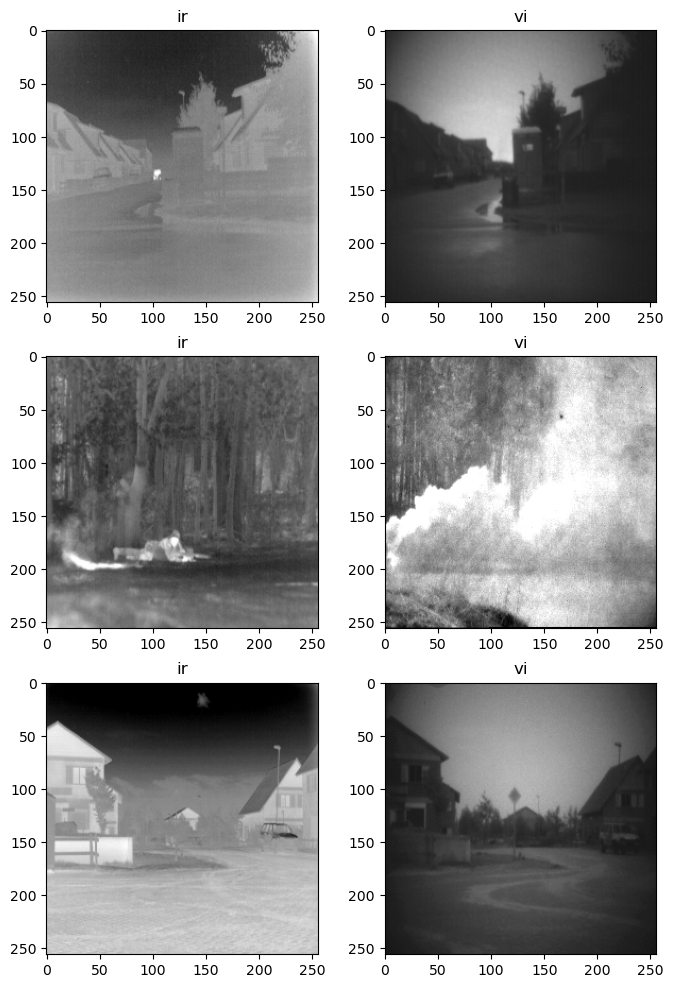

In [14]:
plt.figure(figsize = (8,12))
for i,(vi,ir) in enumerate(zip(ir_batch[:3],vi_batch[:3])):
    ir = (ir.permute(1,2,0).numpy()+1)/2
    vi = (vi.permute(1,2,0).numpy()+1)/2
    plt.subplot(3,2,2*i+1)
    plt.title('ir')
    plt.imshow(ir)

    plt.subplot(3,2,2*i+2)
    plt.title('vi')
    plt.imshow(vi)

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.LeakyReLU(True)
        )
        # Define the decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        # print(f'初始图像：{x.shape}')
        x = self.encoder(x)
        # print(f'编码器图像：{x.shape}')
        x = self.decoder(x)
        # print(f'解码器图像：{x.shape}')
        return x

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
AE = Autoencoder()
AE = AE.to(device)
# if torch.cuda.device_count() > 1:
#     AE = nn.DataParallel(AE)

In [18]:
optimizer = torch.optim.Adam(AE.parameters(),
                            lr = 1e-4,betas=(0.5,0.999))

In [19]:
loss_fn = torch.nn.MSELoss()

In [20]:
losses = []

In [21]:
epochs = 200

In [22]:
for epoch in range(epochs):
    for item,img in enumerate(train_dl):
        img = img.to(device)
        pred = AE(img)
        # Calculating the loss function
        loss = loss_fn(pred, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Storing the losses in a list for plotting
        losses.append(loss)
    print(f'epoch:{epoch},loss:{loss}')

epoch:0,loss:0.12663871049880981
epoch:1,loss:0.08518841117620468
epoch:2,loss:0.031381383538246155
epoch:3,loss:0.043219298124313354
epoch:4,loss:0.023818939924240112
epoch:5,loss:0.029780542477965355
epoch:6,loss:0.024941246956586838
epoch:7,loss:0.017913684248924255
epoch:8,loss:0.024277783930301666
epoch:9,loss:0.013479690067470074
epoch:10,loss:0.015612998977303505
epoch:11,loss:0.031441088765859604
epoch:12,loss:0.023437267169356346
epoch:13,loss:0.007968909107148647
epoch:14,loss:0.018761061131954193
epoch:15,loss:0.022029204294085503
epoch:16,loss:0.02322390489280224
epoch:17,loss:0.020068664103746414
epoch:18,loss:0.011140286922454834
epoch:19,loss:0.017435379326343536
epoch:20,loss:0.010713658295571804
epoch:21,loss:0.01230688951909542
epoch:22,loss:0.030517300590872765
epoch:23,loss:0.018420368432998657
epoch:24,loss:0.0083493422716856
epoch:25,loss:0.013236373662948608
epoch:26,loss:0.011481071822345257
epoch:27,loss:0.008064665831625462
epoch:28,loss:0.01466138195246458
ep

In [23]:
fusion_model = AE.encoder

In [24]:
def calculate_metrics(vi, ir,fusion):
    # Information Entropy (EN)
    def calculate_entropy(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        entropy_value = shannon_entropy(img_gray)
        return entropy_value

    # Standard Deviation (SD)
    def calculate_sd(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        sd_value = np.std(img_gray)
        return sd_value

    # Structural Similarity Index (SSIM)
    def calculate_ssim(vi, ir ,fusion):
        img1_gray = cv2.cvtColor(vi, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
        fusion_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        ssim_index_A, _ = ssim(img1_gray, fusion_gray, full=True)
        ssim_index_B, _ = ssim(img2_gray, fusion_gray, full=True)
        return (ssim_index_A + ssim_index_B)/2 

    

    # Correlation Coefficient (CC)
    def calculate_cc(vi, ir ,fusion):
        img1_flat = vi.flatten()
        img2_flat = ir.flatten()
        fusion_flat = fusion.flatten()
        
        correlation_coefficient_A = np.corrcoef(img1_flat, fusion_flat)[0, 1]
        correlation_coefficient_B = np.corrcoef(img2_flat, fusion_flat)[0, 1]
        
        return (correlation_coefficient_A + correlation_coefficient_B)/2

    # Spatial Frequency (SF)
    def calculate_sf(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        f = np.fft.fft2(img_gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        spatial_frequency = np.sum(magnitude_spectrum) / img_gray.size
        return spatial_frequency

    # Variable Luminance Fusion Index (VLF)
    def calculate_vlf(vi, ir ,fusion):
        img1_gray = cv2.cvtColor(vi, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
        fusion_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        
        vlf_value_A = np.sum(np.abs(img1_gray - fusion_gray)) / img1_gray.size
        vlf_value_B = np.sum(np.abs(img2_gray - fusion_gray)) / img2_gray.size
        
        return (vlf_value_A + vlf_value_B)/2

    # Calculate metrics
    entropy_value = calculate_entropy(fusion)
    sd_value = calculate_sd(fusion)
    ssim_value = calculate_ssim(vi, ir,fusion)
    cc_value = calculate_cc(vi, ir,fusion)
    sf_value = calculate_sf(fusion)
    vlf_value = calculate_vlf(vi, ir,fusion)
    return {
        'Entropy': entropy_value,
        'Standard Deviation': sd_value,
        'SSIM': ssim_value,
        'Correlation Coefficient': cc_value,
        'Spatial Frequency': sf_value,
        'Variable Luminance Fusion Index': vlf_value
    }

In [27]:
def genarate_images(ir,vi,fusion):
    fusion = fusion.permute(0,2,3,1).detach().cpu().numpy()
    ir = ir.permute(0,2,3,1).detach().cpu().numpy()
    vi = vi.permute(0,2,3,1).detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    display_list = [ir[0],vi[0],fusion[0]]

    fusion_result = calculate_metrics(vi[0], ir[0],fusion[0])
    print(fusion_result)
    title = ['ir','vi','fusion']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()
    return fusion_result

torch.Size([16, 512, 16, 16]) torch.Size([16, 512, 16, 16])
torch.Size([16, 3, 256, 256])
{'Entropy': 15.998992919921879, 'Standard Deviation': 0.24285479, 'SSIM': 0.11640838812228227, 'Correlation Coefficient': 0.3850657987634523, 'Spatial Frequency': 0.024585921331615745, 'Variable Luminance Fusion Index': 0.4318898618221283}


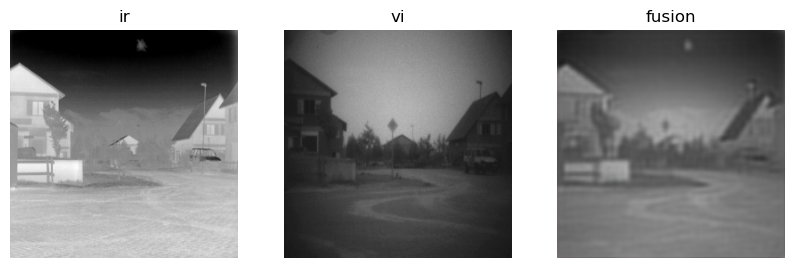

torch.Size([16, 512, 16, 16]) torch.Size([16, 512, 16, 16])
torch.Size([16, 3, 256, 256])
{'Entropy': 15.998870849609375, 'Standard Deviation': 0.21787551, 'SSIM': 0.2044604574778121, 'Correlation Coefficient': 0.5392176446223235, 'Spatial Frequency': 5.274191163379879, 'Variable Luminance Fusion Index': 0.21076145768165588}


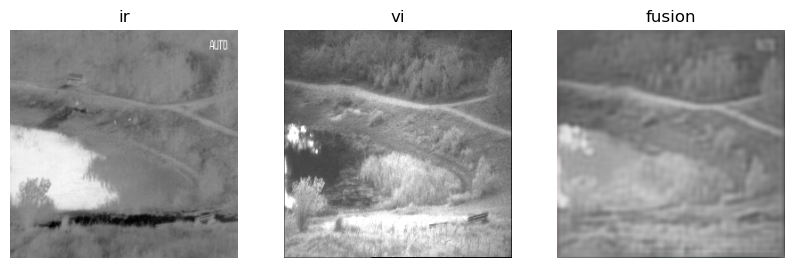

torch.Size([10, 512, 16, 16]) torch.Size([10, 512, 16, 16])
torch.Size([10, 3, 256, 256])
{'Entropy': 15.997528076171877, 'Standard Deviation': 0.3220955, 'SSIM': 0.12317872071423007, 'Correlation Coefficient': 0.6564655685858071, 'Spatial Frequency': 16.41169354335359, 'Variable Luminance Fusion Index': 0.5100434571504593}


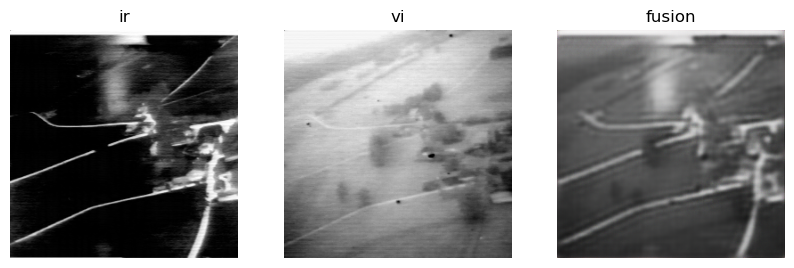

In [29]:
for item,(vi,ir) in enumerate(fusion_dl):
    # print(vi.shape,ir.shape)
    vi = vi.to(device)
    ir = ir.to(device)
    with torch.no_grad():
        vi_f = AE.encoder(vi)
        ir_f = AE.encoder(ir)
        print(vi_f.shape,ir_f.shape)
        fusion_img = 0.5 * vi_f + 0.5 * ir_f
        fusion_img = AE.decoder(fusion_img)
        print(fusion_img.shape)
        genarate_images(ir,vi,fusion_img)